# Inteligência Artificial e Aprendizado de Máquina

**Prof. Dr. Francisco de Assis Boldt**  
**Pós-graduação em Desenvolvimento de Aplicações Inteligentes**  
**Inteligência Artificial e Aprendizado de Máquina — Atividade 01 - Regressão**  

**Nome:** Otávio Lube dos Santos  
**Matrícula:** 20231DEVAI0157

In [74]:
# from sklearn.datasets import load_iris
# dataset = load_iris()

from sklearn.datasets import load_wine
dataset = load_wine()

X, y = dataset.data, dataset.target

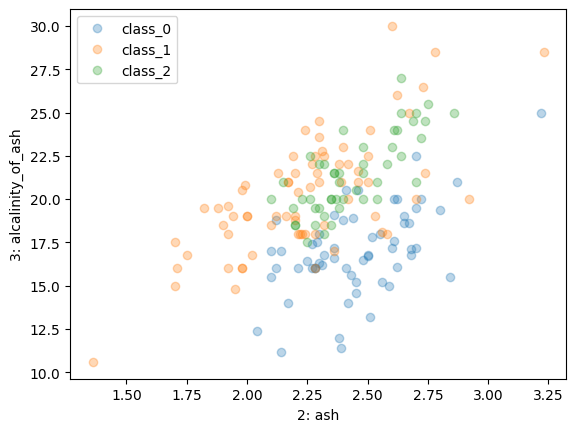

In [75]:
import matplotlib.pyplot as plt
i, j = 2, 3
plt.xlabel(f"{i}: {dataset.feature_names[i]}")
plt.ylabel(f"{j}: {dataset.feature_names[j]}")

for k in set(y):
  plt.plot(X[:,i][y==k], X[:,j][y==k], 'o', alpha=0.3,
           label=f"{dataset.target_names[k]}")
plt.legend()
plt.show()

In [76]:
from sklearn.base import BaseEstimator, ClassifierMixin
from collections import Counter
import numpy as np
from sklearn.model_selection import cross_validate

def maisFrequente(y):
  return Counter(y.flat).most_common(1)[0][0]

class ZeroR(BaseEstimator, ClassifierMixin):
  def fit(self, X, y):
    self.resposta = maisFrequente(y)
    return self
  def predict(self, X, y=None):
    y = np.empty((X.shape[0]))
    y[:] = self.resposta
    return y

scores = cross_validate(ZeroR(), X, y)
scores['test_score'], np.mean(scores['test_score'])

(array([0.        , 0.36111111, 0.        , 0.        , 0.        ]),
 np.float64(0.07222222222222222))

In [77]:
modelo = ZeroR()
modelo.fit(X, y)
modelo.resposta

np.int64(1)

In [78]:
modelo = ZeroR()
modelo.fit(X, y)
ypred = modelo.predict(X)
sum(y==ypred)/len(y)

np.float64(0.398876404494382)

In [79]:
class Arvore(BaseEstimator, ClassifierMixin):
  def fit(self, X, y):
    self.caracteristica = 2
    self.valor = np.mean(X[:,self.caracteristica])
    maiores = X[:,self.caracteristica] > self.valor
    if sum(maiores)>0 and sum(~maiores)>0:
      self.maiores = Arvore()
      self.maiores.fit(X[maiores,:], y[maiores])
      self.menores = Arvore()
      self.menores.fit(X[~maiores,:], y[~maiores])
    else:
      self.resposta = maisFrequente(y)
    return self
  def predict(self, X, y=None):
    y = np.empty((X.shape[0]))
    if hasattr(self, 'resposta'):
      y[:] = self.resposta
    else:
      maiores = X[:,self.caracteristica] > self.valor
      y[maiores] = self.maiores.predict(X[maiores,:])
      y[~maiores] = self.menores.predict(X[~maiores,:])
    return y

modelo = Arvore()
modelo.fit(X, y)
ypred = modelo.predict(X)
sum(y==ypred)/len(y)

np.float64(0.702247191011236)

In [80]:
scores = cross_validate(Arvore(), X, y)
scores['test_score'], np.mean(scores['test_score'])

(array([0.05555556, 0.30555556, 0.25      , 0.25714286, 0.14285714]),
 np.float64(0.20222222222222222))

In [81]:
def impureza(y): #Gini
  labels = list(set(y))
  labels.sort()
  probabilidades = np.zeros((len(labels),))
  for i, k in enumerate(labels):
    probabilidades[i] = sum(y==k)/len(y)
  result = 1 - sum(probabilidades ** 2)
  return result

impureza(y[:])

np.float64(0.6583133442747129)

In [82]:
def impurezaValor(x, y, valor):
  maiores = x > valor
  impurezamaiores = impureza(y[maiores])
  proporcaomaiores = sum(maiores)/len(y)
  impurezamenores = impureza(y[~maiores])
  proporcaomenores = sum(~maiores)/len(y)
  impurezaTotal = proporcaomaiores*impurezamaiores + proporcaomenores*impurezamenores
  return impurezaTotal, impurezamenores, impurezamaiores

impurezaValor(X[:,2], y, 2.5)

(np.float64(0.6434985114760395),
 np.float64(0.6419753086419754),
 np.float64(0.647189349112426))

In [83]:
def melhorValor(x, y):
  result = None
  menorImpureza = float('inf')
  xmax = np.max(x)
  xmin = np.min(x)
  while True:
    valor = (xmin+xmax)/2
    impTotal, impMenores, impMaiores = impurezaValor(x, y, valor)
    if impTotal < menorImpureza:
      menorImpureza = impTotal
      result = valor
      if impMaiores == 0 or impMenores == 0:
        break
      if impMaiores < impMenores:
        xmin = valor
      else:
        xmax = valor
    else:
      break
  return result, menorImpureza

melhorValor(X[:,2], y)

(np.float64(2.295), np.float64(0.6139307817100282))

In [84]:
def melhorCaracteristica(X, y):
  impurezas = []
  valores = []
  for caracteristica in range(X.shape[1]):
    valor, imp = melhorValor(X[:,caracteristica], y)
    impurezas.append(imp)
    valores.append(valor)
  # print(impurezas)
  # print(valores)
  impurezas = np.array(impurezas)
  caracteristica = np.argmin(impurezas)
  return impurezas[caracteristica], caracteristica, valores[caracteristica]

melhorCaracteristica(X, y)

(np.float64(0.43761750381193476), np.int64(12), np.float64(979.0))

In [87]:
class Arvore(BaseEstimator, ClassifierMixin):
  def fit(self, X, y):
    # if X.shape[1] <= self.caracteristica:
    #     self.caracteristica = X.shape[1] - 1
    self.impureza, self.caracteristica, self.valor = melhorCaracteristica(X, y)
    maiores = X[:,self.caracteristica] > self.valor
    if sum(maiores)>0 and sum(~maiores)>0:
      self.maiores = Arvore()
      self.maiores.fit(X[maiores,:], y[maiores])
      self.menores = Arvore()
      self.menores.fit(X[~maiores,:], y[~maiores])
    else:
      self.resposta = maisFrequente(y)
    return self
  def predict(self, X, y=None):
    y = np.empty((X.shape[0]))
    if hasattr(self, 'resposta'):
      y[:] = self.resposta
    else:
      maiores = X[:,self.caracteristica] > self.valor
      y[maiores] = self.maiores.predict(X[maiores,:])
      y[~maiores] = self.menores.predict(X[~maiores,:])
    return y

modelo = Arvore()
modelo.fit(X, y)
ypred = modelo.predict(X)
sum(y==ypred)/len(y)

np.float64(1.0)

## Na função de Melhor Valor


In [112]:
def melhorValor_novo(x, y):
    if len(x) <= 1:  # Verifique se há valores suficientes
        return None, float("inf")
    
    # Ordena os valores da característica e os rótulos correspondentes
    sorted_indices = np.argsort(x)
    x_sorted, y_sorted = x[sorted_indices], y[sorted_indices]

    # Calcula as médias consecutivas
    valores_medios = (x_sorted[:-1] + x_sorted[1:]) / 2

    melhor_valor = None
    menor_impureza = float('inf')

    for valor in valores_medios:
        maiores = x > valor
        menores = ~maiores

        # Calcula impurezas para os conjuntos maiores e menores
        impureza_maiores = impureza(y[maiores]) if sum(maiores) > 0 else 0
        impureza_menores = impureza(y[menores]) if sum(menores) > 0 else 0

        # Calcula a impureza total ponderada
        proporcao_maiores = sum(maiores) / len(y)
        proporcao_menores = sum(menores) / len(y)

        impureza_total = (proporcao_maiores * impureza_maiores +
                          proporcao_menores * impureza_menores)

        if impureza_total < menor_impureza:
            menor_impureza = impureza_total
            melhor_valor = valor

    return melhor_valor, menor_impureza

## Nova Melhor Característica

In [113]:
def melhorCaracteristica_novo(X, y):
    melhor_impureza = float("inf")
    melhor_caracteristica = None
    melhor_valor = None

    for caracteristica in range(X.shape[1]):
        valor, impureza = melhorValor_novo(X[:, caracteristica], y)
        if valor is not None and impureza < melhor_impureza:
            melhor_impureza = impureza
            melhor_caracteristica = caracteristica
            melhor_valor = valor

    # Retorna None se nenhuma característica válida for encontrada
    if melhor_caracteristica is None or melhor_valor is None:
        return None

    return melhor_impureza, melhor_caracteristica, melhor_valor


In [114]:
class ArvoreNova(BaseEstimator, ClassifierMixin):
    def __init__(self, heuristica="original"):
        self.heuristica = heuristica

    def fit(self, X, y):
        # Verifica se há dados suficientes para dividir
        if len(X) <= 1:
            self.resposta = Counter(y).most_common(1)[0][0]
            return self

        # Seleciona a melhor característica e valor de divisão
        resultado = melhorCaracteristica_novo(X, y)

        if resultado is None or resultado[1] is None or resultado[2] is None:
            # Caso não encontre um valor válido, atribui a resposta mais frequente
            self.resposta = Counter(y).most_common(1)[0][0]
            return self

        self.impureza, self.caracteristica, self.valor = resultado

        # Divide os dados com base no valor selecionado
        maiores = X[:, self.caracteristica] > self.valor
        menores = ~maiores

        if sum(maiores) > 0 and sum(menores) > 0:
            self.maiores = ArvoreNova()
            self.maiores.fit(X[maiores, :], y[maiores])
            self.menores = ArvoreNova()
            self.menores.fit(X[menores, :], y[menores])
        else:
            self.resposta = Counter(y).most_common(1)[0][0]

        return self

    def predict(self, X):
        y = np.empty(X.shape[0], dtype=int)
        if hasattr(self, "resposta"):
            y[:] = self.resposta
        else:
            maiores = X[:, self.caracteristica] > self.valor
            y[maiores] = self.maiores.predict(X[maiores, :])
            y[~maiores] = self.menores.predict(X[~maiores, :])
        return y


In [92]:
scores = cross_validate(Arvore(), X, y)
scores['test_score'], np.mean(scores['test_score'])

(array([0.91666667, 0.63888889, 0.86111111, 0.85714286, 0.68571429]),
 np.float64(0.7919047619047619))

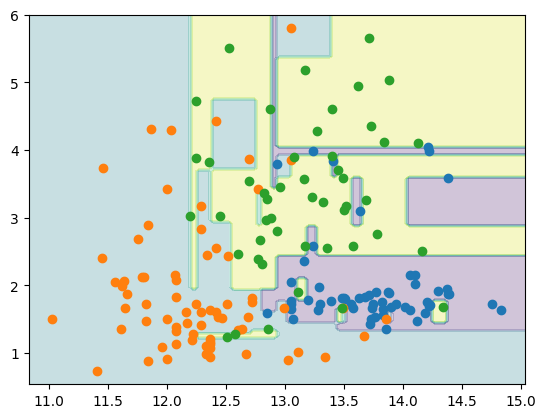

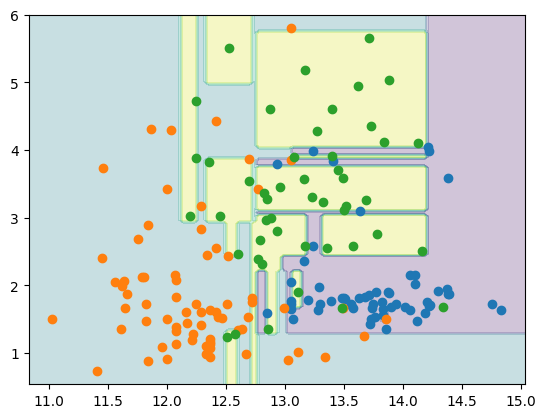

In [115]:
import matplotlib.pyplot as plt

def plotDecisao(modelo, X, y):
  X = X[:, :2]  # Reduza para 2 dimensões antes de treinar
  modelo.fit(X, y)
  x0s = np.linspace(np.min(X[:,0])-0.2, np.max(X[:,0])+0.2, 100)
  x1s = np.linspace(np.min(X[:,1])-0.2, np.max(X[:,1])+0.2, 100)
  x0, x1 = np.meshgrid(x0s, x1s)
  Xdec = np.c_[x0.ravel(), x1.ravel()]
  ypred = modelo.predict(Xdec)
  plt.contourf(x0, x1, ypred.reshape(x0.shape), alpha=0.25)
  for k in set(y):
    plt.plot(X[:,0][y==k], X[:,1][y==k], 'o')
  plt.show()

plotDecisao(Arvore(), X[:, :], y)
plotDecisao(ArvoreNova(), X[:, :], y)



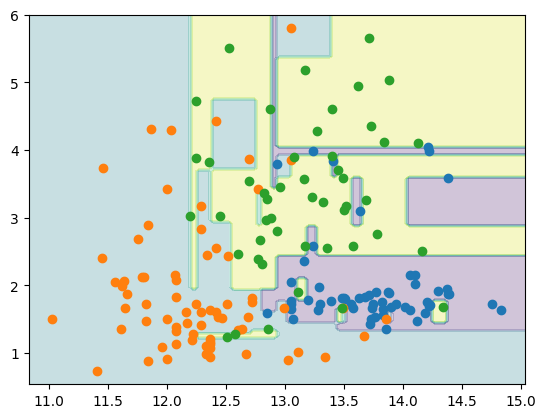

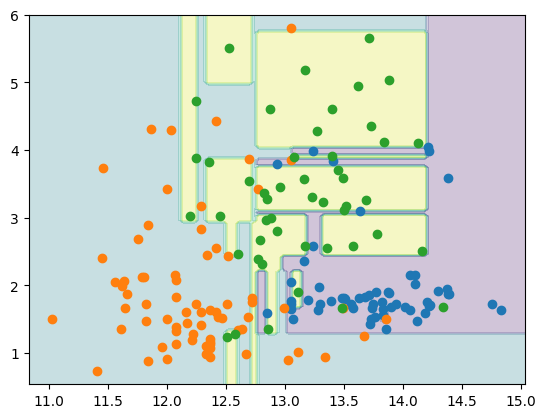

In [116]:
plotDecisao(Arvore(), X[:,:2], y)
plotDecisao(ArvoreNova(), X[:,:2], y)

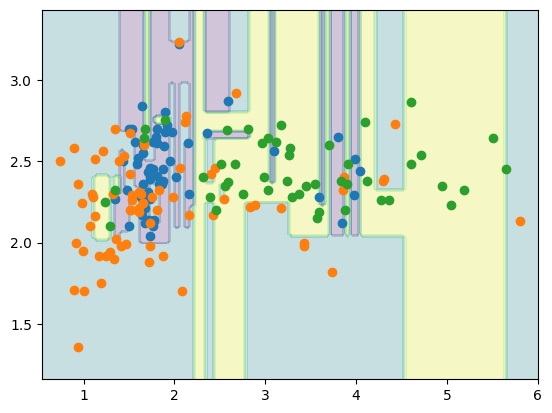

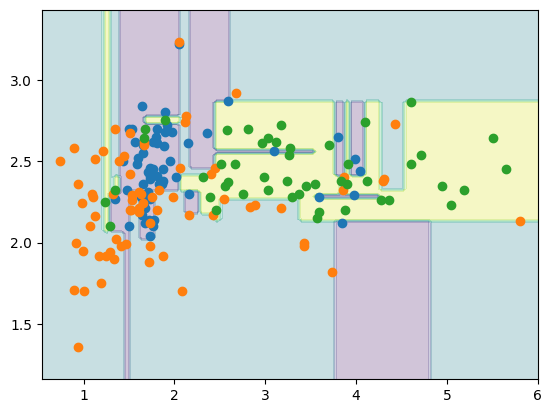

In [117]:
plotDecisao(Arvore(), X[:,1:3], y)
plotDecisao(ArvoreNova(), X[:,1:3], y)

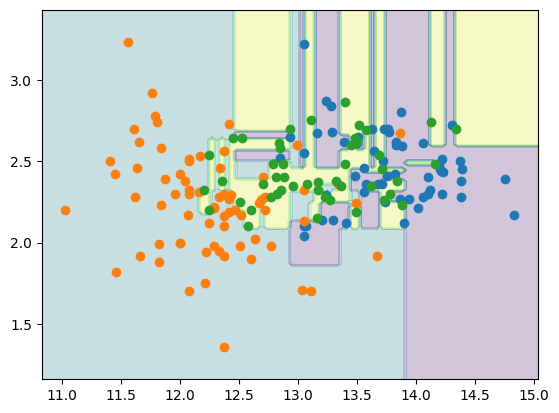

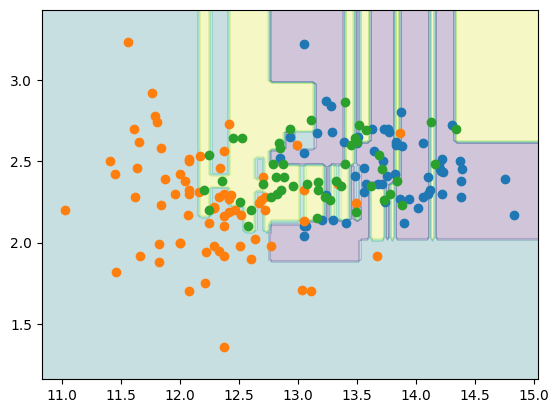

In [118]:
plotDecisao(Arvore(), X[:,[0,2]], y)
plotDecisao(ArvoreNova(), X[:,[0,2]], y)

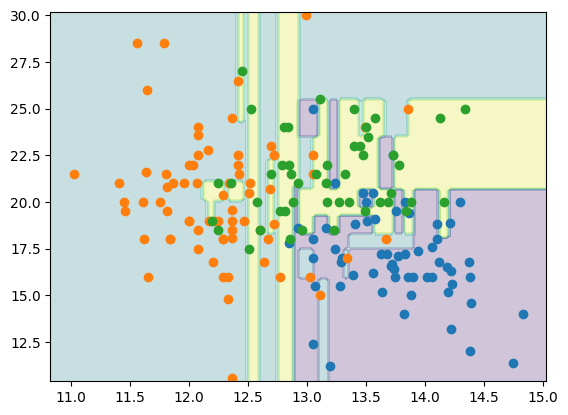

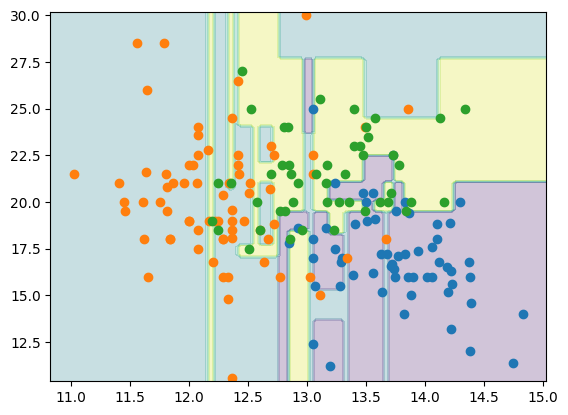

In [119]:
plotDecisao(Arvore(), X[:,[0,3]], y)
plotDecisao(ArvoreNova(), X[:,[0,3]], y)

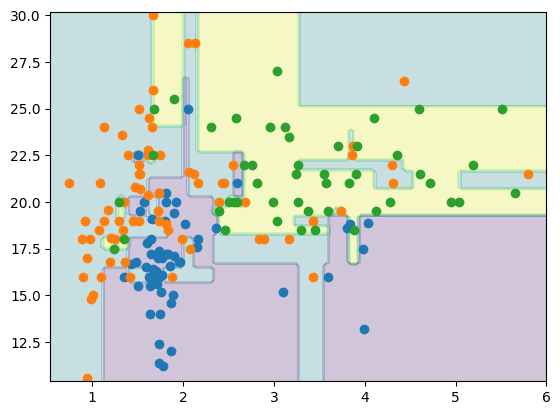

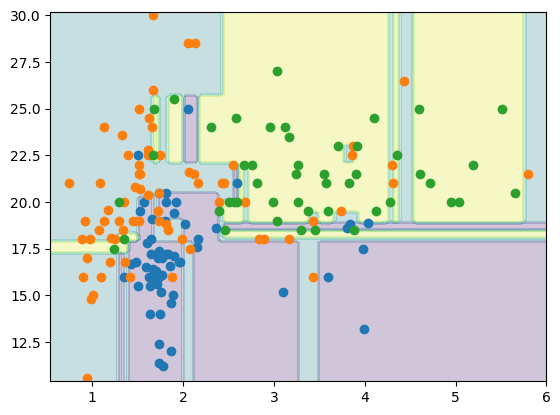

In [120]:
plotDecisao(Arvore(), X[:,[1,3]], y)
plotDecisao(ArvoreNova(), X[:,[1,3]], y)

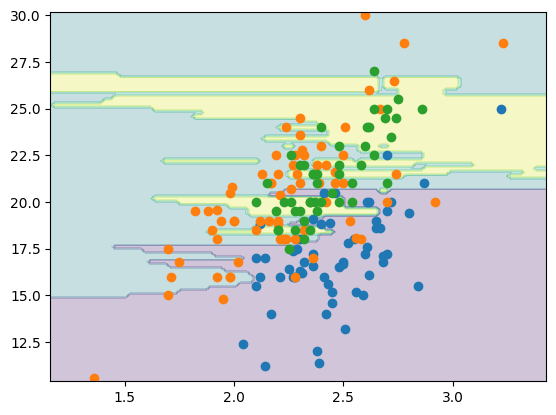

In [101]:
from sklearn.neighbors import KNeighborsClassifier
plotDecisao(KNeighborsClassifier(), X[:,2:], y)

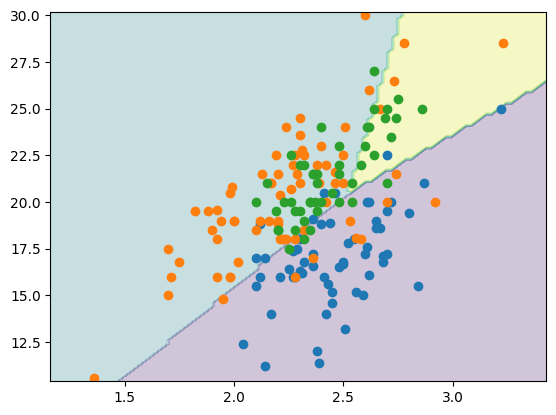

In [102]:
from sklearn.svm import LinearSVC
plotDecisao(LinearSVC(), X[:,2:], y)

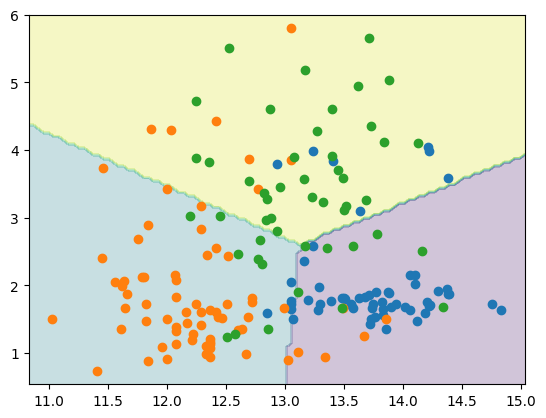

In [ ]:
plotDecisao(LinearSVC(), X[:,:2], y)

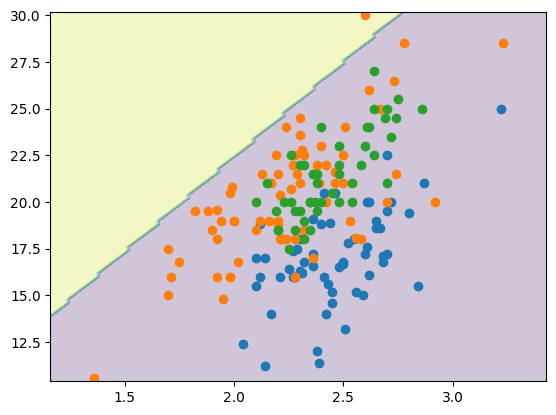

In [ ]:
from sklearn.linear_model import Perceptron
plotDecisao(Perceptron(), X[:,2:], y)

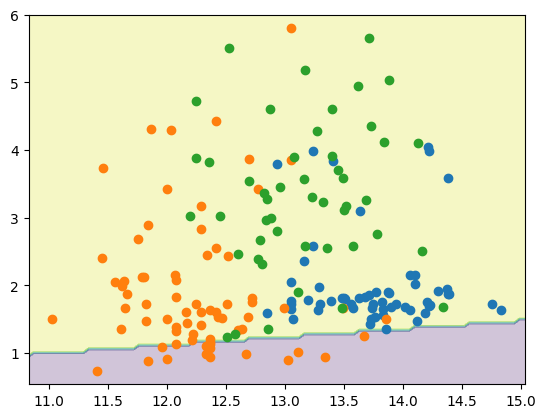

In [ ]:
plotDecisao(Perceptron(), X[:,:2], y)

## Comparação de desempenho

In [121]:
import time
from sklearn.model_selection import cross_validate

# Comparação entre heurísticas
start = time.time()
scores_original = cross_validate(Arvore(), X, y)
tempo_original = time.time() - start

start = time.time()
scores_novo = cross_validate(ArvoreNova(), X, y)
tempo_novo = time.time() - start

# Resultados
print("Heurística Original:")
print("Precisão:", np.mean(scores_original['test_score']))
print("Tempo de Treinamento:", tempo_original)

print("\nHeurística Nova:")
print("Precisão:", np.mean(scores_novo['test_score']))
print("Tempo de Treinamento:", tempo_novo)

Heurística Original:
Precisão: 0.7919047619047619
Tempo de Treinamento: 0.22397518157958984

Heurística Nova:
Precisão: 0.8368253968253969
Tempo de Treinamento: 3.8939781188964844
